In [1]:
pip install numpy scipy scikit-learn matplotlib libpysal



     ---------------------------------------- 0.0/51.5 kB ? eta -:--:--
     ----------------------- ---------------- 30.7/51.5 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 51.5/51.5 kB 878.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
    --------------------------------------- 0.1/2.8 MB 1.3 MB/s eta 0:00:03
   - -------------------------------------- 0.1/2.8 MB 991.0 kB/s eta 0:00:03
   - -------------------------------------- 0.1/2.8 MB 871.5 kB/s eta 0:00:04
   -- ------------------------------------- 0.2/2.8 MB 930.9 kB/s eta 0:00:03
   --- ------------------------------------ 0.2/2.8 MB 1.0 MB/s eta 0:00:03
   ---- ----------------------------------- 0.3/2.8 MB 1.1 MB/s eta 0:00:03
   ----- ---------------------------------- 0.4/2.8 MB 1.1 MB/s eta 0:00:03
   ------ --------------------------------- 0.4/2.8 MB 1.2 MB/s eta 0:00:03
   ------- -------------------------------- 0.5/2.8 MB 1.2 MB/s eta 0:00:02
   -----

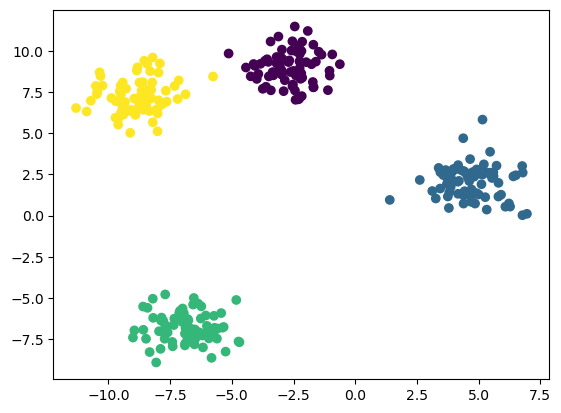

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Create a synthetic dataset
n_samples = 300
n_features = 2
n_clusters = 4
X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()


In [4]:
from libpysal.weights import KNN
from libpysal.weights import full

# Create a K-nearest neighbors weight matrix
knn = KNN.from_array(X, k=5)
W_tuple = full(knn)
W = W_tuple[0]  # Extract the weight matrix from the tuple
W = W / W.sum(axis=1)[:, None]  # Row-standardize the weight matrix

# Ensure W is symmetric
W = (W + W.T) / 2


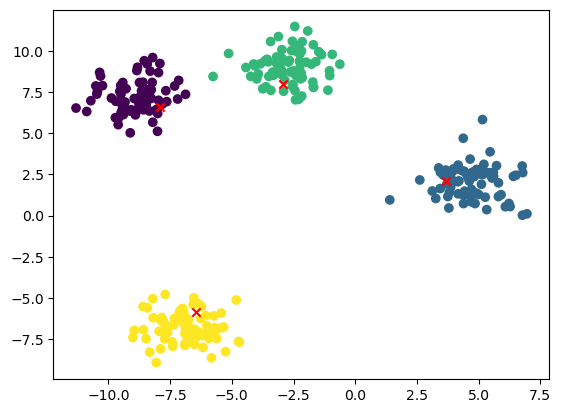

In [5]:
from scipy.spatial.distance import cdist

def spatial_fuzzy_cmeans(X, W, n_clusters=4, m=1.5, alpha=0.7, max_iter=150, tol=1e-4):
    n_samples, n_features = X.shape

    # Initialize cluster centers randomly
    np.random.seed(42)
    centers = X[np.random.choice(n_samples, n_clusters, replace=False)]

    # Initialize membership matrix randomly
    U = np.random.dirichlet(np.ones(n_clusters), size=n_samples)

    for iteration in range(max_iter):
        U_old = U.copy()

        # Calculate cluster centers
        V = np.zeros((n_clusters, n_features))
        for i in range(n_clusters):
            numerator = np.dot((U[:, i] ** m + alpha * (W @ U[:, i] ** m)), X)
            denominator = (U[:, i] ** m + alpha * (W @ U[:, i] ** m)).sum()
            V[i] = numerator / denominator

        # Update membership matrix
        distances = cdist(X, V, metric='euclidean')
        for i in range(n_samples):
            for j in range(n_clusters):
                denom = sum([(distances[i, j] + alpha * np.dot(W[i], distances[:, k])) ** (-2 / (m - 1)) for k in range(n_clusters)])
                U[i, j] = (distances[i, j] + alpha * np.dot(W[i], distances[:, j])) ** (-2 / (m - 1)) / denom

        # Check for convergence
        if np.linalg.norm(U - U_old) < tol:
            break

    return V, U

centers, membership_matrix = spatial_fuzzy_cmeans(X, W)

# Visualize the clustering
cluster_labels = np.argmax(membership_matrix, axis=1)
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels)
plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='red')
plt.show()
